# **Summary**

This notebook makes use of Random Forest Classifier to determine if a candidate will win based on the following features.

1. 'can_par_aff' (A candidate's party has great impact on his/her success in the election)
2. 'ind_con'
3. 'net_ope_exp'
4. 'tot_con'
5. 'tot_dis'
6. 'net_con'
7. 'ope_exp'
8. 'tot_rec'
9. 'can_inc_cha_ope_sea' (Based on a study; The Effect of Open Seats on Challenger Strength in Japanese Lower House Elections by John Hickman, OPEN seats tend to attract strong challengers who in turn look to maximize their chance of success)

The ***Random Forest Classifier*** is based on:
1. A imbalanced data, 
2. A balanced data after smoting
3. Dummy Encoding was used on 'can_par_aff' and 'can_inc_cha_ope_sea'.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-of-rep/H_df.csv


In [2]:
# read our dataset
df = pd.read_csv("/kaggle/input/house-of-rep/H_df.csv")

# **Our Dataset**

In [3]:
# display first 5 rows
df.head(5)

can_id           can_nam can_off can_off_sta  can_off_dis can_par_aff  \
0  H2GA12121  ALLEN, RICHARD W       H          GA         12.0         REP   
1  H6PA02171     EVANS, DWIGHT       H          PA          2.0         DEM   
2  H6FL04105  RUTHERFORD, JOHN       H          FL          4.0         REP   
3  H4MT01041     ZINKE, RYAN K       H          MT          0.0         REP   
4  H8CA09060      LEE, BARBARA       H          CA         13.0         DEM   

  can_inc_cha_ope_sea                 can_str1       can_cit can_sta  ...  \
0           INCUMBENT          2237 PICKENS RD       AUGUSTA      GA  ...   
1          CHALLENGER              PO BOX 6578  PHILADELPHIA      PA  ...   
2                OPEN  3817 VICKERS LAKE DRIVE  JACKSONVILLE      FL  ...   
3           INCUMBENT             409 2ND ST W     WHITEFISH      MT  ...   
4           INCUMBENT     409 13TH ST, 17TH FL       OAKLAND      CA  ...   

   cas_on_han_beg_of_per cas_on_han_clo_of_per         net_con net_ope_exp  \
0            $60,109.57           $175,613.35   $1,074,949.50     907156.2   
1                    NaN          $105,687.23   $1,406,719.06    1298831.9   
2                    NaN           $35,645.09     $650,855.38     656210.3   
3            $83,815.78           $399,122.61   $4,938,943.74    5055942.0   
4            $83,690.60           $181,338.23   $1,197,676.61     949489.0   

   deb_owe_by_com cov_sta_dat cov_end_dat winner     votes campaign_duration  
0  $1,125,000.00   2015-01-01  2016-10-19      Y  158708.0               657  
1             NaN  2015-11-02  2016-10-19      Y  310770.0               352  
2     $60,000.00   2016-04-01  2016-10-19      Y  286018.0               201  
3             NaN  2015-01-01  2016-10-19      Y  280476.0               657  
4      $4,401.75   2015-01-01  2016-10-19      Y  277390.0               657  

[5 rows x 42 columns]

In [4]:
# running a quick analysis report with pandas_profiling
from pandas_profiling import ProfileReport
report = ProfileReport(df)
report.to_file(output_file='dataset_report.html')

In [5]:
# display the report
report

In [6]:
# visio imports
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# model imports
import pickle
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Feature Engineering
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

# Performance analysis
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [7]:
np.random.seed(23)

In [8]:
data = df.copy()

# remove the id column
data = data.iloc[:, 1:]

**Plot a corr heatmap of our dataset**

In [9]:
corr = data.corr()

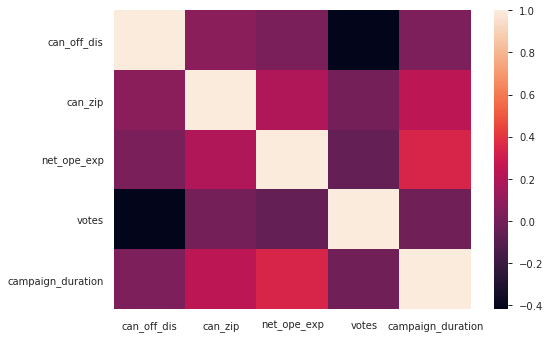

In [10]:
sns.heatmap(corr)

In [11]:
# check for all na values in our dataset
df.isna().count()

can_id                   1429
can_nam                  1429
can_off                  1429
can_off_sta              1429
can_off_dis              1429
can_par_aff              1429
can_inc_cha_ope_sea      1429
can_str1                 1429
can_cit                  1429
can_sta                  1429
can_zip                  1429
ind_ite_con              1429
ind_uni_con              1429
ind_con                  1429
par_com_con              1429
oth_com_con              1429
can_con                  1429
tot_con                  1429
tra_fro_oth_aut_com      1429
can_loa                  1429
tot_loa                  1429
off_to_ope_exp           1429
oth_rec                  1429
tot_rec                  1429
ope_exp                  1429
can_loa_rep              1429
tot_loa_rep              1429
ind_ref                  1429
oth_com_ref              1429
tot_con_ref              1429
oth_dis                  1429
tot_dis                  1429
cas_on_han_beg_of_per    1429
cas_on_han

**From our analysis, we find out that there is atleast 1 missing value at every row in our dataset, using dropna() would drop all rows in our dataset.
Therefore, we would reduce our dataset to only what we would be using, then dropna values.**

In [12]:
df = df[['can_par_aff', 'ind_con', 'net_ope_exp', 'tot_con', 'tot_dis', 'net_con', 'ope_exp', 'tot_rec', 'can_inc_cha_ope_sea', 'winner']]

In [13]:
# removing unnecessary details from our dataset($ and ,)
df[df.columns] = df[df.columns].replace({'\$': '', ',': ''}, regex=True)

In [14]:
# dropping all na values
df = df.dropna()

In [15]:
# extract our independent (x_data) and dependent/target variables/features (y_data)
x_data = df.drop("winner")
y_data = df['winner']

In [17]:
# check the Dtype of our columns
x_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1333 entries, 0 to 1426
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   can_par_aff          1333 non-null   object 
 1   ind_con              1333 non-null   object 
 2   net_ope_exp          1333 non-null   float64
 3   tot_con              1333 non-null   object 
 4   tot_dis              1333 non-null   object 
 5   net_con              1333 non-null   object 
 6   ope_exp              1333 non-null   object 
 7   tot_rec              1333 non-null   object 
 8   can_inc_cha_ope_sea  1333 non-null   object 
dtypes: float64(1), object(8)
memory usage: 104.1+ KB


In [18]:
# convert the columns to float64
x_data["ind_con"] = pd.to_numeric(x_data["ind_con"])
x_data["net_ope_exp"] = pd.to_numeric(x_data["net_ope_exp"])
x_data["tot_con"] = pd.to_numeric(x_data["tot_con"])
x_data["tot_dis"] = pd.to_numeric(x_data["tot_dis"])
x_data["ope_exp"] = pd.to_numeric(x_data["ope_exp"])
x_data["tot_rec"] = pd.to_numeric(x_data["tot_rec"])

In [19]:
# we noticed a value in the dataset as (933.00) so we have to get rid of the brackets
# an easy way would be to change the value directly
x_data["net_con"][981:982] = 933.00

In [20]:
# finally, we convert that column to float64
x_data["net_con"] = pd.to_numeric(x_data["net_con"])

In [21]:
# checking the dtype of x_data to confirm our changes were registered
x_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1333 entries, 0 to 1426
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   can_par_aff          1333 non-null   object 
 1   ind_con              1333 non-null   float64
 2   net_ope_exp          1333 non-null   float64
 3   tot_con              1333 non-null   float64
 4   tot_dis              1333 non-null   float64
 5   net_con              1333 non-null   float64
 6   ope_exp              1333 non-null   float64
 7   tot_rec              1333 non-null   float64
 8   can_inc_cha_ope_sea  1333 non-null   object 
dtypes: float64(7), object(2)
memory usage: 104.1+ KB


**Encoding the categorical data**

In [22]:
# next, we use the one-hot encoding approach to encode the categorical features in x_data
x_data = pd.get_dummies(x_data)

In [23]:
# taking a look at our data
x_data

ind_con  net_ope_exp     tot_con     tot_dis     net_con     ope_exp  \
0      601274.50    907156.20  1074949.50   978518.98  1074949.50   908518.98   
1     1114711.02   1298831.90  1417545.22  1313583.69  1406719.06  1300557.53   
2      542105.38    656210.30   650855.38   675642.76   650855.38   656642.76   
3     4317331.58   5055942.00  4980915.41  5200630.00  4938943.74  5073110.33   
4      897123.61    949489.00  1205863.61  1112163.94  1197676.61   953436.94   
...          ...          ...         ...         ...         ...         ...   
1422   213756.00    459834.75   213756.00   462392.04   212756.00   460070.80   
1423     3318.96      3111.94     3318.96     3318.96     3111.94     3111.94   
1424    12889.00     13356.89    14241.00    13983.11    14241.00    13356.89   
1425    95538.35    247121.34   102538.35   247121.35   102538.35   247121.35   
1426    25808.00    528638.40   140858.00   538358.00   140858.00   528638.39   

         tot_rec  can_par_aff_CON  can_par_aff_DEM  can_par_aff_DFL  ...  \
0     1094022.76                0                0                0  ...   
1     1419270.92                0                1                0  ...   
2      711287.85                0                0                0  ...   
3     5190887.78                0                0                0  ...   
4     1209811.57                0                1                0  ...   
...          ...              ...              ...              ...  ...   
1422   462392.04                0                0                0  ...   
1423     3318.96                0                1                0  ...   
1424    14241.00                0                0                0  ...   
1425   247121.35                0                0                0  ...   
1426   538358.00                0                0                0  ...   

      can_par_aff_NPA  can_par_aff_NPP  can_par_aff_OTH  can_par_aff_PPT  \
0                   0                0                0                0   
1                   0                0                0                0   
2                   0                0                0                0   
3                   0                0                0                0   
4                   0                0                0                0   
...               ...              ...              ...              ...   
1422                0                0                0                0   
1423                0                0                0                0   
1424                0                0                0                0   
1425                0                0                0                0   
1426                0                0                0                0   

      can_par_aff_REP  can_par_aff_UNK  can_par_aff_W  \
0                   1                0              0   
1                   0                0              0   
2                   1                0              0   
3                   1                0              0   
4                   0                0              0   
...               ...              ...            ...   
1422                1                0              0   
1423                0                0              0   
1424                0                0              0   
1425                1                0              0   
1426                1                0              0   

      can_inc_cha_ope_sea_CHALLENGER  can_inc_cha_ope_sea_INCUMBENT  \
0                                  0                              1   
1                                  1                              0   
2                                  0                              0   
3                                  0                              1   
4                                  0                              1   
...                              ...                            ...   
1422                        

In [24]:
# converting our target values to numbers Y = 1, N = 0
y_data['winner'] = y_data['winner'].apply(lambda val: int(val=='Y'))

# verify the data
y_data

winner
0          1
1          1
2          1
3          1
4          1
...      ...
1422       0
1423       0
1424       0
1425       0
1426       0

[1333 rows x 1 columns]

Next, we split our data into train and test sets. Also we'd standardize the data with StandardScaler

In [25]:
# splitting the data
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1)

# Initiating our standardscaler instance
Ss = StandardScaler()

x_train = Ss.fit_transform(x_train) 
x_train = pd.DataFrame(x_train)
x_test = Ss.transform(x_test)

In [26]:
x_train

0         1         2         3         4         5         6   \
0    0.344125  0.396727  1.042851  1.013483  1.049101  0.400588  1.004846   
1   -0.466108 -0.511773 -0.543210 -0.553273 -0.545004 -0.512685 -0.574603   
2   -0.622822 -0.586602 -0.646095 -0.631577 -0.642185 -0.587313 -0.666168   
3   -0.446055 -0.473274 -0.528520 -0.512258 -0.523966 -0.474291 -0.529587   
4    0.938008  0.386287  0.681494  0.629983  0.685876  0.385547  0.575981   
..        ...       ...       ...       ...       ...       ...       ...   
928 -0.614966 -0.570827 -0.626810 -0.616447 -0.622794 -0.571581 -0.652295   
929 -0.604188 -0.585565 -0.634279 -0.630582 -0.630305 -0.586279 -0.659237   
930 -0.257298 -0.383987 -0.414407 -0.431936 -0.409226 -0.385244 -0.454890   
931  3.783756  2.307924  3.337953  2.168968  3.356479  2.299407  3.263855   
932 -0.251507 -0.178231  0.469971  0.127695  0.477200 -0.173094  0.375578   

           7         8         9   ...        16        17        18  \
0   -0.046349  1.151817 -0.046349  ... -0.056796 -0.032756 -0.056796   
1   -0.046349 -0.868193 -0.046349  ... -0.056796 -0.032756 -0.056796   
2   -0.046349  1.151817 -0.046349  ... -0.056796 -0.032756 -0.056796   
3   -0.046349 -0.868193 -0.046349  ... -0.056796 -0.032756 -0.056796   
4   -0.046349  1.151817 -0.046349  ... -0.056796 -0.032756 -0.056796   
..        ...       ...       ...  ...       ...       ...       ...   
928 -0.046349 -0.868193 -0.046349  ... -0.056796 -0.032756 -0.056796   
929 -0.046349  1.151817 -0.046349  ... -0.056796 -0.032756 -0.056796   
930 -0.046349  1.151817 -0.046349  ... -0.056796 -0.032756 -0.056796   
931 -0.046349 -0.868193 -0.046349  ... -0.056796 -0.032756 -0.056796   
932 -0.046349 -0.868193 -0.046349  ... -0.056796 -0.032756 -0.056796   

           19        20        21        22        23        24        25  
0   -0.032756 -1.042712 -0.056796 -0.032756 -0.959038  1.600334 -0.562084  
1   -0.032756  0.959038 -0.056796 -0.032756  1.042712 -0.624870 -0.562084  
2   -0.032756 -1.042712 -0.056796 -0.032756  1.042712 -0.624870 -0.562084  
3   -0.032756  0.959038 -0.056796 -0.032756 -0.959038 -0.624870  1.779095  
4   -0.032756 -1.042712 -0.056796 -0.032756 -0.959038  1.600334 -0.562084  
..        ...       ...       ...       ...       ...       ...       ...  
928 -0.032756  0.959038 -0.056796 -0.032756  1.042712 -0.624870 -0.562084  
929 -0.032756 -1.042712 -0.056796 -0.032756  1.042712 -0.624870 -0.562084  
930 -0.032756 -1.042712 -0.056796 -0.032756 -0.959038 -0.624870  1.779095  
931 -0.032756  0.959038 -0.056796 -0.032756 -0.959038  1.600334 -0.562084  
932 -0.032756  0.959038 -0.056796 -0.032756 -0.959038  1.600334 -0.562084  

[933 rows x 26 columns]

# Train Our Models

Random Forest

In [27]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf, x_train,y_train, cv=5)
print(cv)
print(cv.mean())

[0.92513369 0.96256684 0.95721925 0.91397849 0.91935484]
0.9356506238859179


RF Accuracy 0.96
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       260
           1       0.92      0.97      0.94       140

    accuracy                           0.96       400
   macro avg       0.95      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400

[[248  12]
 [  4 136]]


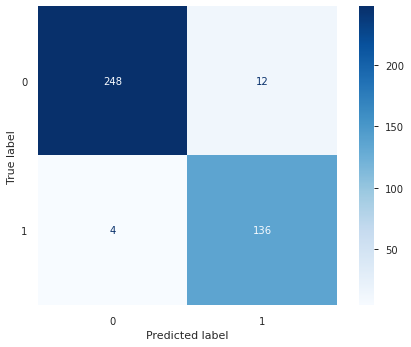

In [28]:
# fit and make predictions

rf.fit(x_train, y_train)
rf_y_pred = rf.predict(x_test)
print('RF Accuracy {:.2f}'.format(rf.score(x_test, y_test)))

print(classification_report(y_test, rf_y_pred)) 

from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(rf, x_test, y_test, cmap=plt.cm.Blues)
print(disp.confusion_matrix)

plt.show()

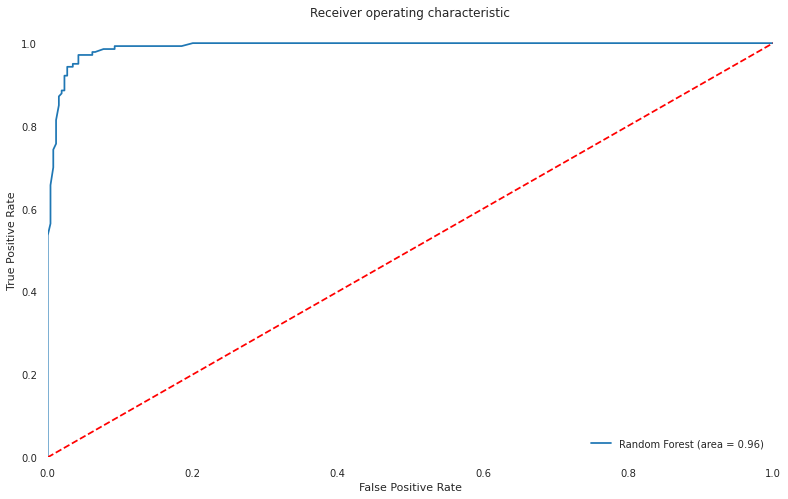

In [29]:
rf_roc_auc = roc_auc_score(y_test, rf.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(x_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Support Vector Classifier

In [30]:
svc = SVC(probability = True)
cv = cross_val_score(svc,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.9144385  0.94652406 0.96256684 0.91935484 0.93010753]
0.9345983554712207


SVC Accuracy 0.95
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       260
           1       0.95      0.91      0.93       140

    accuracy                           0.95       400
   macro avg       0.95      0.94      0.95       400
weighted avg       0.95      0.95      0.95       400

[[253   7]
 [ 12 128]]


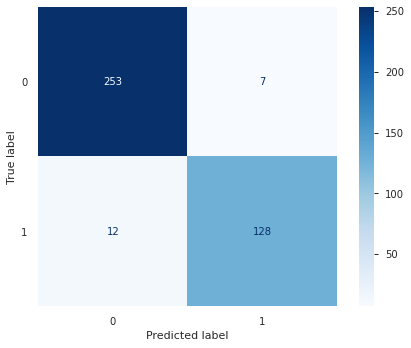

In [31]:
# fit and make predictions

svc.fit(x_train, y_train)
svc_y_pred = svc.predict(x_test)
print('SVC Accuracy {:.2f}'.format(svc.score(x_test, y_test)))

print(classification_report(y_test, svc_y_pred)) 

disp = plot_confusion_matrix(svc, x_test, y_test, cmap=plt.cm.Blues)
print(disp.confusion_matrix)

plt.show()

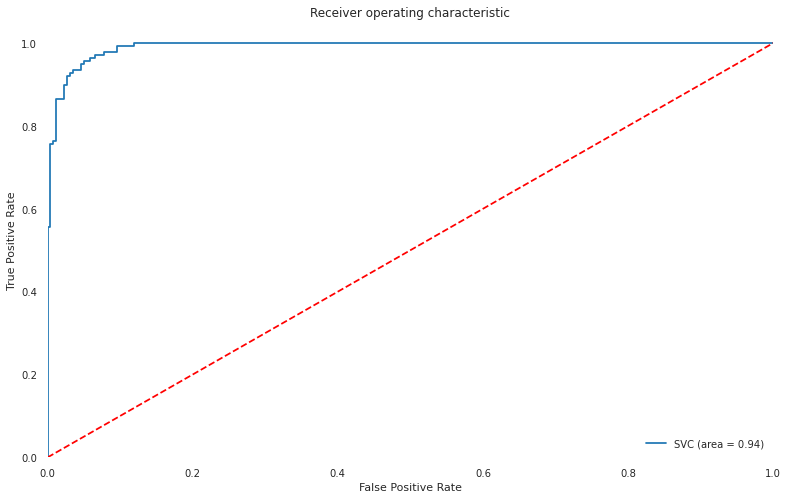

In [32]:
svc_roc_auc = roc_auc_score(y_test, svc.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, svc.predict_proba(x_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='SVC (area = %0.2f)' % svc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

XGBoost

In [33]:
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.93048128 0.96256684 0.95721925 0.91397849 0.91397849]
0.9356448737852914


XGBoost Classifier Accuracy 0.96
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       260
           1       0.93      0.95      0.94       140

    accuracy                           0.96       400
   macro avg       0.95      0.96      0.95       400
weighted avg       0.96      0.96      0.96       400

[[250  10]
 [  7 133]]


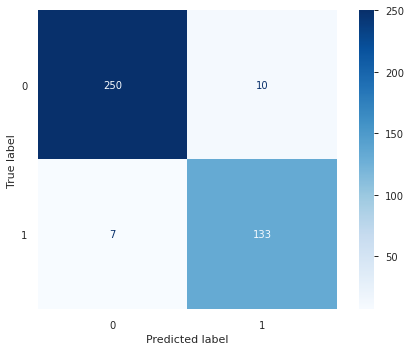

In [34]:
xgb_train = x_train.sort_index(axis=1)

# fit and make predictions

xgb.fit(x_train.values, y_train)
xgb_y_pred = xgb.predict(x_test)
print('XGBoost Classifier Accuracy {:.2f}'.format(xgb.score(x_test, y_test)))

print(classification_report(y_test, xgb_y_pred)) 

disp = plot_confusion_matrix(xgb, x_test, y_test, cmap=plt.cm.Blues)
print(disp.confusion_matrix)

plt.show()

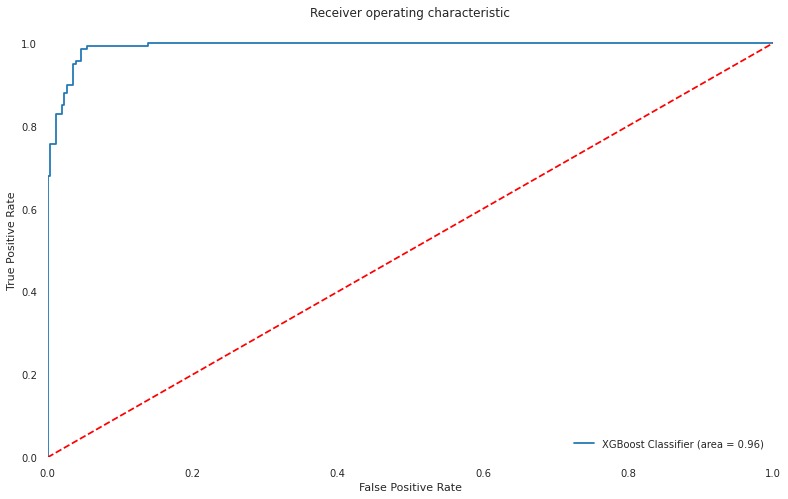

In [35]:
xgb_roc_auc = roc_auc_score(y_test, xgb.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(x_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='XGBoost Classifier (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# **Ensembling Approach**

We introduce the ensembling approach in order to a better classifier by aggregating the predictions of each classifier and predict the class that gets the most votes. (Hard voting)

In [47]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('rf',rf),('svc',svc),('xgb',xgb)], voting = 'hard') 

cv = cross_val_score(voting_clf,x_train, y_train,cv=5)
print(cv)
print(cv.mean())

[0.94117647 0.96256684 0.95721925 0.91935484 0.93010753]
0.9420849864872636


RF Accuracy 0.96
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       260
           1       0.93      0.96      0.95       140

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400

[[250  10]
 [  5 135]]


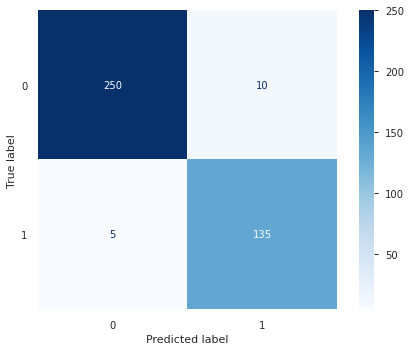

In [52]:
# fit and make predictions
voting_clf.fit(x_train.values, y_train)
voting_clf_y_pred = voting_clf.predict(x_test)
print('RF Accuracy {:.2f}'.format(voting_clf.score(x_test, y_test)))

print(classification_report(y_test, voting_clf_y_pred)) 

from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(voting_clf, x_test, y_test, cmap=plt.cm.Blues)
print(disp.confusion_matrix)

plt.show()

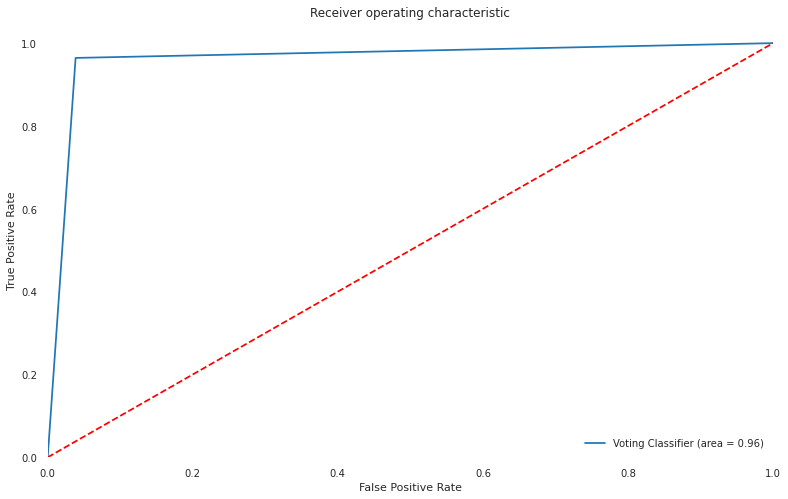

In [54]:
voting_clf_roc_auc = roc_auc_score(y_test, voting_clf.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, voting_clf.predict(x_test))
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='Voting Classifier (area = %0.2f)' % voting_clf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# **GridSearchCV + SMOTE (handling the imbalance in our data)**

So far, it appears our Random Forest Model performs better than every other model we've tried.
We can still try using GridSearchCV, and SMOTE on our RF model in an attempt to get better value, else we go with the initial performance of our Model.

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1)

# balance the data with SMOTE
smote = SMOTE(random_state=0)
columns = x_train.columns
smote_x,smote_y=smote.fit_sample(x_train, y_train) 

# Then we scale with StandardScaler
x_train, x_test, y_train, y_test = train_test_split(smote_x, smote_y, test_size=0.3, random_state=0)
Ss = StandardScaler() 
x_train = Ss.fit_transform(x_train) 
x_train = pd.DataFrame(x_train)
x_test = Ss.transform(x_test)

In [56]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [57]:
# hyperparameters which gridsearch would iterate through.
param_grid =  {
                'n_estimators': [400,450,500,550],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25, 30],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}

clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(x_train,y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 17.2min finished


Random Forest
Best Score: 0.9552005523821482
Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}


RF Accuracy 0.96
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       191
           1       0.96      0.95      0.96       192

    accuracy                           0.96       383
   macro avg       0.96      0.96      0.96       383
weighted avg       0.96      0.96      0.96       383

[[183   8]
 [  9 183]]


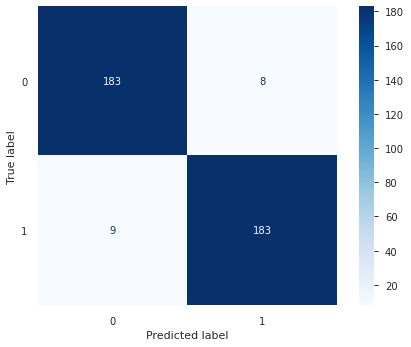

In [58]:
# fit and make predictions
clf_rf_y_pred = clf_rf.predict(x_test)
print('RF Accuracy {:.2f}'.format(clf_rf.score(x_test, y_test)))

#print model classification report
print(classification_report(y_test, clf_rf_y_pred)) 

#plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(clf_rf, x_test, y_test, cmap=plt.cm.Blues)
print(disp.confusion_matrix)

#display plot
plt.show()

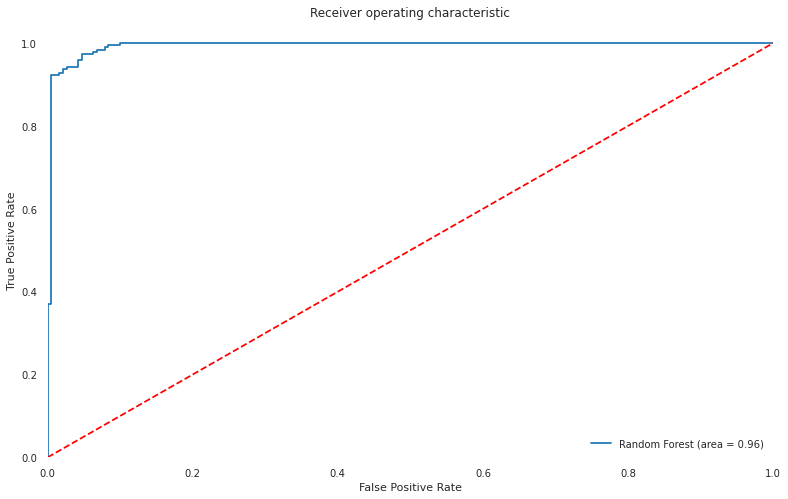

In [59]:
#plot ROC curve of our model
clf_rf_roc_auc = roc_auc_score(y_test, clf_rf.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, clf_rf.predict_proba(x_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % clf_rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [46]:
# save our model
filename = "rf(smote)_model.pkl"  
with open(filename, 'wb') as file:  
    pickle.dump(clf_rf, file)